In [56]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
titanic_df = pd.read_csv('train.csv')

In [58]:
test_df = pd.read_csv('test.csv')

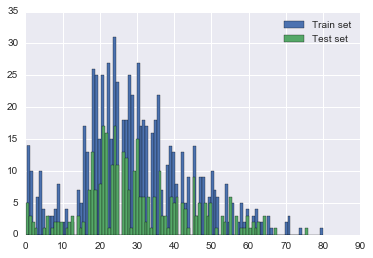

In [59]:
#Need to fill missing values for age so will explore that first
titanic_df['Age'].hist(bins=100, label="Train set")
test_df['Age'].hist(bins=100, label="Test set")
plt.legend()

In [60]:
#There doesn't appear to be any outliers so can replace all NaN values with median
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

In [61]:
#Define who is a child, female adult and male adult:
def child_female_male(passenger):
    Age, Sex = passenger
    if Age < 16:
        return 'child'
    else:
        return Sex

In [62]:
#Create new column to define if passenger was child/female/male
titanic_df['Type'] = titanic_df[['Age', 'Sex']].apply(child_female_male, axis = 1)
test_df['Type'] = test_df[['Age', 'Sex']].apply(child_female_male, axis = 1)

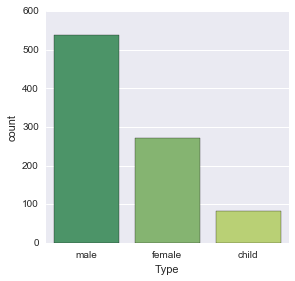

In [63]:
#plot this
sns.factorplot('Type',data=titanic_df, kind="count", palette='summer')

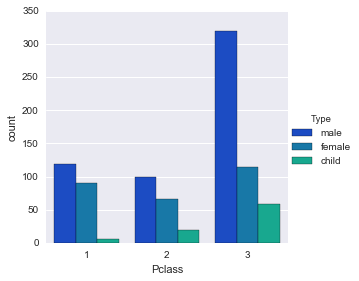

In [64]:
#Type of person in each class
sns.factorplot('Pclass', data=titanic_df, kind='count', hue='Type', x_order=(1,2,3), palette='winter')

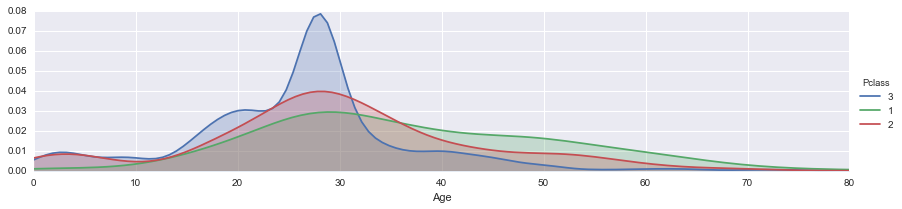

In [65]:
#Take a look at the dispersion of age in the different classes in the training set
fig = sns.FacetGrid(titanic_df, hue='Pclass', aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
fig.set(xlim=(0,titanic_df['Age'].max()))
fig.add_legend()

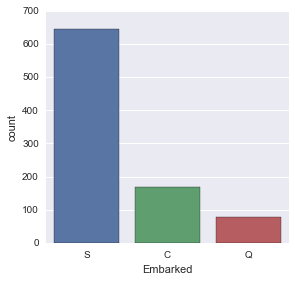

In [66]:
#Where passengers embarked from
sns.factorplot('Embarked', data=titanic_df, kind='count')

In [67]:
#Fill NaN value for "Embarked" with most common value
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

In [68]:
#Map each object to an integer
titanic_df['Type'] = titanic_df['Type'].map({'male': 0, 'female': 1, 'child':2})
test_df['Type'] = test_df['Type'].map({'male':0, 'female':1, 'child':2})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'C':0, 'Q':1, 'S':2})
test_df['Embarked'] = test_df['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [69]:
#Look who had family and who didn't
titanic_df['Family'] = titanic_df['Parch'] + titanic_df['SibSp']
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0


test_df['Family'] = test_df['Parch'] + test_df['SibSp']
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

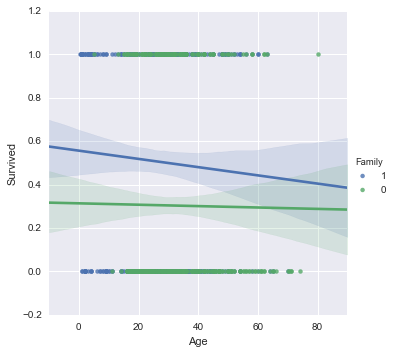

In [70]:
#Can view linear relationships between different features and Survived
#Younger passengers with family had a higher chance of surviving
sns.lmplot('Age', 'Survived', hue='Family', data=titanic_df)

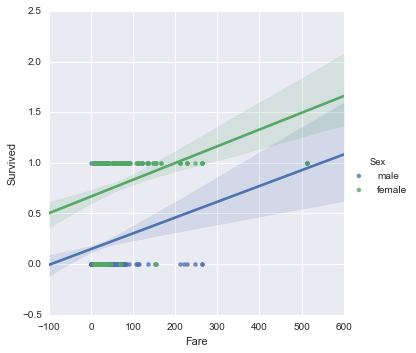

In [71]:
#Those who paid a higher Fare also had a higher chance of surving
sns.lmplot('Fare', 'Survived', hue='Sex', data=titanic_df)

In [72]:
#Members of a small family (<5) had a higher chance of survival so merge train set and test set
titanic_all = pd.concat([titanic_df, test_df], ignore_index=True)
titanic_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null int64
Family         1309 non-null int64
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Type           1309 non-null int64
dtypes: float64(3), int64(7), object(4)
memory usage: 153.4+ KB


In [73]:
#Look who had family that was 5 or larger
titanic_all['Small_fam'] = titanic_all['Parch'] + titanic_all['SibSp'] + 1
titanic_all['Small_fam'].loc[titanic_all['Small_fam'] >= 5] = 0
titanic_all['Small_fam'].loc[titanic_all['Small_fam'] < 5] = 1

In [74]:
#Split back into train set and test set
titanic_df = titanic_all[:891]

In [75]:
test_df = titanic_all[891:]
test_df = test_df.reset_index(drop=True)

In [76]:
#Replace the one NaN value in test set 'Fare'
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

In [77]:
#Convert Fare to int value
titanic_df['Fare']= titanic_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

/Users/CL/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [78]:
#Drop unnecessary features
titanic_df = titanic_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId', 'Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Survived'], axis=1)

In [79]:
X_train = titanic_df.drop(["Survived"],axis=1)
Y_train = titanic_df["Survived"]

X_test  = test_df.drop("PassengerId",axis=1).copy()

In [80]:
from sklearn.preprocessing import Imputer
X_train = Imputer().fit_transform(X_train)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [82]:
Xcross_train, Xcross_test, ycross_train, ycross_test = cross_validation.train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0)

In [83]:
#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200,
    min_samples_split=4,
    min_samples_leaf=2)
clf = clf.fit(Xcross_train, ycross_train)

In [91]:
clf.score(Xcross_test, ycross_test)

0.84357541899441346

In [95]:
y_pred = clf.predict(X_test).astype(int)

In [97]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'],'Survived': y_pred})
submission.to_csv('titanic_submission1.csv', index=False)

In [98]:
from sklearn.metrics import classification_report
from sklearn import metrics
y_true, y_pred = ycross_test, clf.predict(Xcross_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.84      0.93      0.88       110
        1.0       0.86      0.71      0.78        69

avg / total       0.85      0.84      0.84       179



In [99]:
#Try Logistic Regression
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

In [100]:
clf = logistic.fit(Xcross_train, ycross_train)

In [101]:
clf.score(Xcross_test, ycross_test)

0.78770949720670391

In [102]:
y_pred = clf.predict(X_test).astype(int)

In [103]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'],'Survived': y_pred})
submission.to_csv('titanic_submission2.csv', index=False)

In [104]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [105]:
clf = gnb.fit(Xcross_train, ycross_train)

In [107]:
clf.score(Xcross_test, ycross_test)

0.73184357541899436

In [333]:
from sklearn import svm

In [334]:
clf7 = svm.SVC()

In [335]:
clf7 = clf7.fit(Xcross_train, ycross_train)

In [336]:
clf7.score(Xcross_test, ycross_test)

0.7039106145251397

In [111]:
from sklearn.ensemble import ExtraTreesClassifier

In [113]:
clf = ExtraTreesClassifier(n_estimators=100, max_depth=None,min_samples_split=1, random_state=0)

In [114]:
clf = clf.fit(Xcross_train, ycross_train)

In [115]:
clf.score(Xcross_test, ycross_test)

0.82681564245810057

0.42870387284466077